## 1. Import Pakcage

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

## 2. Load Dataset

In [2]:
data = pd.read_csv('online_retail_listing.csv', sep=';', encoding='unicode_escape')

## 3. Data Understanding

In [3]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1048575 non-null  object 
 1   StockCode    1048575 non-null  object 
 2   Description  1044203 non-null  object 
 3   Quantity     1048575 non-null  int64  
 4   InvoiceDate  1048575 non-null  object 
 5   Price        1048575 non-null  object 
 6   Customer ID  811893 non-null   float64
 7   Country      1048575 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 64.0+ MB


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,1.12.2009 07:45,"6,95",13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,1.12.2009 07:45,"6,75",13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,1.12.2009 07:45,"6,75",13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,1.12.2009 07:45,"2,1",13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,1.12.2009 07:45,"1,25",13085.0,United Kingdom


In [4]:
data.isnull().sum()

Invoice             0
StockCode           0
Description      4372
Quantity            0
InvoiceDate         0
Price               0
Customer ID    236682
Country             0
dtype: int64

## 4. Data Preprocessing

In [5]:
data = data.dropna(subset=['Description'])
data = data[~(data['Invoice'].str[0] == 'C')]
data = data[~(data['Quantity'] <= 0)]
data['Customer ID'] = data['Customer ID'].fillna(0.0).astype(int)

In [6]:
data['Price'] = data['Price'].str.replace(',','.').astype(float)
data.InvoiceDate = pd.to_datetime(data.InvoiceDate)

In [7]:
data['date'] = data['InvoiceDate'].dt.date
data['time'] = data['InvoiceDate'].dt.time
data = data.drop(columns=['InvoiceDate'])
data.date = pd.to_datetime(data.date)

In [8]:
data = data[data['Description'].str.isupper()]

In [9]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1019830 entries, 0 to 1048574
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1019830 non-null  object        
 1   StockCode    1019830 non-null  object        
 2   Description  1019830 non-null  object        
 3   Quantity     1019830 non-null  int64         
 4   Price        1019830 non-null  float64       
 5   Customer ID  1019830 non-null  int32         
 6   Country      1019830 non-null  object        
 7   date         1019830 non-null  datetime64[ns]
 8   time         1019830 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(5)
memory usage: 73.9+ MB


,Invoice,StockCode,Description,Quantity,Price,Customer ID,Country,date,time
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,6.95,13085,United Kingdom,2009-01-12,07:45:00
1,489434,79323P,PINK CHERRY LIGHTS,12,6.75,13085,United Kingdom,2009-01-12,07:45:00
2,489434,79323W,WHITE CHERRY LIGHTS,12,6.75,13085,United Kingdom,2009-01-12,07:45:00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2.10,13085,United Kingdom,2009-01-12,07:45:00
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,1.25,13085,United Kingdom,2009-01-12,07:45:00


## 5. Data Visualization

In [10]:
country = data.groupby('Country')['Invoice'].count().reset_index().sort_values('Invoice', ascending=False)

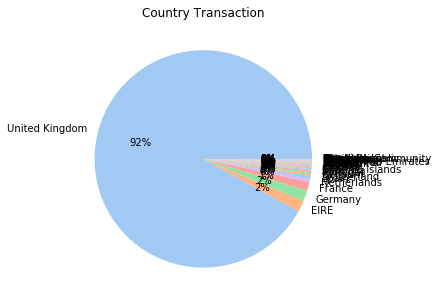

In [11]:
plt.figure(figsize=(12,5))
colors = sns.color_palette('pastel')[0:5]
plt.title('Country Transaction')
plt.pie(country['Invoice'], labels = country['Country'], colors = colors, autopct='%.0f%%')
plt.show()

Text(0, 0.5, 'Country')

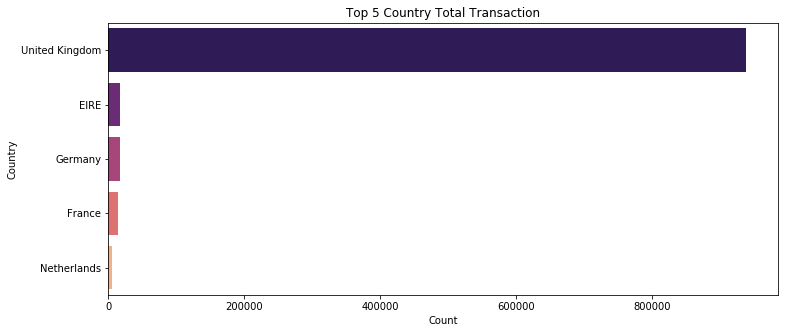

In [12]:
Top_5_Country=country.head(5)
plt.figure(figsize=(12,5))
plt.title('Top 5 Country Total Transaction')
sns.barplot(y='Country',x='Invoice', data=Top_5_Country, palette = 'magma')
plt.xlabel('Count')
plt.ylabel('Country')

In [13]:
item = pd.DataFrame(data.groupby('Description')['Quantity'].sum())

Text(0, 0.5, 'Qty')

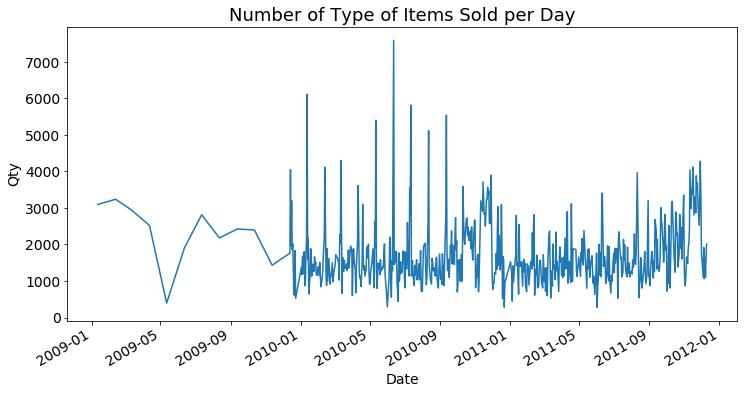

In [14]:
data[['date','Description']].groupby('date').count().plot(figsize=(12,6), legend=False, fontsize=14)
plt.title('Number of Type of Items Sold per Day', fontsize=18)
plt.xlabel('Date',fontsize=14)
plt.ylabel('Qty', fontsize=14)

Text(0, 0.5, 'Qty')

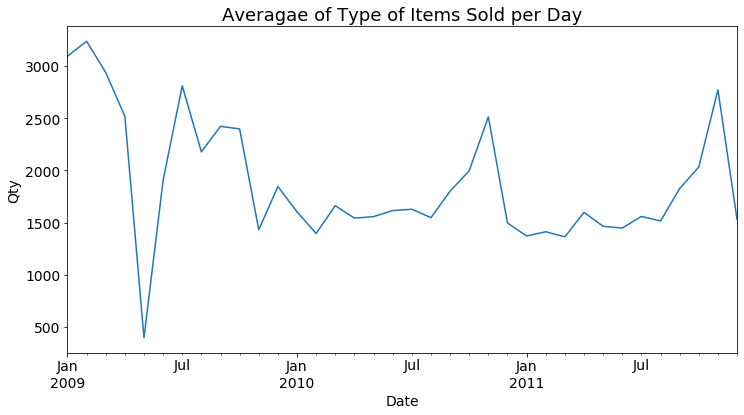

In [15]:
data[['date','Description']].groupby('date').count().resample('M').mean().plot(figsize=(12,6), legend=False, fontsize=14)
plt.title('Averagae of Type of Items Sold per Day', fontsize=18)
plt.xlabel('Date',fontsize=14)
plt.ylabel('Qty', fontsize=14)

## 6. Modelling (Market Basket Analysis)

In [16]:
data_uk = data.loc[data.Country == 'United Kingdom']
data_uk.sample(10)

,Invoice,StockCode,Description,Quantity,Price,Customer ID,Country,date,time
883657,568135,84030E,ENGLISH ROSE HOT WATER BOTTLE,1,8.29,0,United Kingdom,2011-09-23,17:04:00
431494,530612,22443,GROW YOUR OWN HERBS SET OF 3,3,7.95,16712,United Kingdom,2010-03-11,15:45:00
463767,533140,21982,PACK OF 12 SUKI TISSUES,2,0.29,15968,United Kingdom,2010-11-16,13:04:00
7369,490024,21159,MOODY BOY DOOR HANGER,1,1.45,14606,United Kingdom,2009-03-12,12:40:00
234546,512098,85049C,ROMANTIC PINKS RIBBONS,1,1.25,17790,United Kingdom,2010-06-13,13:30:00
358367,524153,72051S,BAG OF SILVER STONES,2,0.84,0,United Kingdom,2010-09-27,15:56:00
391983,527076,22131,FOOD CONTAINER SET 3 LOVE HEART,6,1.95,15677,United Kingdom,2010-10-14,15:19:00
419672,529518,35004C,SET OF 3 COLOURED FLYING DUCKS,4,5.45,17853,United Kingdom,2010-10-28,15:29:00
741692,555835,21989,PACK OF 20 SKULL PAPER NAPKINS,1,0.85,14525,United Kingdom,2011-07-06,12:34:00
209434,509581,22198,LARGE POPCORN HOLDER,12,1.65,14909,United Kingdom,2010-05-24,14:43:00


In [17]:
basket_uk = data_uk.groupby(['Invoice', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('Invoice')
basket_uk

Description,DOORMAT UNION JACK GUNS AND ROSES,3 STRIPEY MICE FELTCRAFT,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,ANIMAL STICKERS,BLACK PIRATE TREASURE CHEST,BROWN PIRATE TREASURE CHEST,CAMPHOR WOOD PORTOBELLO MUSHROOM,CHERRY BLOSSOM DECORATIVE FLASK,DOLLY GIRL BEAKER,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
Invoice,,,,,,,,,,,,,,,,,,,,,
489434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
489435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
489436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
489437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
489438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
580490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
580500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0


In [18]:
def encode_basket(x):
    if x <= 0:
        return 0
    if x >= 0:
        return 1
    
basket_uk_encode = basket_uk.applymap(encode_basket)
basket_uk_encode

Description,DOORMAT UNION JACK GUNS AND ROSES,3 STRIPEY MICE FELTCRAFT,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,ANIMAL STICKERS,BLACK PIRATE TREASURE CHEST,BROWN PIRATE TREASURE CHEST,CAMPHOR WOOD PORTOBELLO MUSHROOM,CHERRY BLOSSOM DECORATIVE FLASK,DOLLY GIRL BEAKER,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
Invoice,,,,,,,,,,,,,,,,,,,,,
489434,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489435,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489436,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489437,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489438,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580482,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
580490,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
580500,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [19]:
basket_uk_filter = basket_uk_encode[(basket_uk_encode > 0).sum(axis=1) >=2]
basket_uk_filter

Description,DOORMAT UNION JACK GUNS AND ROSES,3 STRIPEY MICE FELTCRAFT,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,ANIMAL STICKERS,BLACK PIRATE TREASURE CHEST,BROWN PIRATE TREASURE CHEST,CAMPHOR WOOD PORTOBELLO MUSHROOM,CHERRY BLOSSOM DECORATIVE FLASK,DOLLY GIRL BEAKER,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
Invoice,,,,,,,,,,,,,,,,,,,,,
489434,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489435,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489436,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489437,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489438,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580482,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
580490,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
580500,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [20]:
frequent_itemsets_uk = apriori(basket_uk_filter, min_support = 0.03, use_colnames=True).sort_values('support', ascending=False).reset_index(drop=True)

In [21]:
frequent_itemsets_uk['length'] = frequent_itemsets_uk['itemsets'].apply(lambda x : len(x))
frequent_itemsets_uk

,support,itemsets,length
0,0.157912,(WHITE HANGING HEART T-LIGHT HOLDER),1
1,0.102515,(REGENCY CAKESTAND 3 TIER),1
2,0.091362,(JUMBO BAG RED RETROSPOT),1
3,0.079659,(ASSORTED COLOUR BIRD ORNAMENT),1
4,0.076176,(PARTY BUNTING),1
...,...,...,...
113,0.030495,(LUNCH BAG SUKI DESIGN ),1
114,0.030434,(JAM MAKING SET WITH JARS),1
115,0.030342,(SET OF 3 BUTTERFLY COOKIE CUTTERS),1
116,0.030281,"(SWEETHEART CERAMIC TRINKET BOX, STRAWBERRY CE...",2


In [22]:
association_rules(frequent_itemsets_uk, metric='lift', min_threshold = 1).sort_values('lift', ascending=False).reset_index(drop=True)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(SWEETHEART CERAMIC TRINKET BOX),(STRAWBERRY CERAMIC TRINKET BOX),0.042686,0.065481,0.030281,0.709377,10.833313,0.027486,3.215574
1,(STRAWBERRY CERAMIC TRINKET BOX),(SWEETHEART CERAMIC TRINKET BOX),0.065481,0.042686,0.030281,0.462436,10.833313,0.027486,1.780836
2,(WOODEN PICTURE FRAME WHITE FINISH),(WOODEN FRAME ANTIQUE WHITE ),0.058942,0.060378,0.032939,0.558839,9.255626,0.029380,2.129883
3,(WOODEN FRAME ANTIQUE WHITE ),(WOODEN PICTURE FRAME WHITE FINISH),0.060378,0.058942,0.032939,0.545547,9.255626,0.029380,2.070746
4,(JUMBO STORAGE BAG SUKI),(JUMBO BAG RED RETROSPOT),0.067253,0.091362,0.031870,0.473876,5.186797,0.025725,1.727040
5,(JUMBO BAG RED RETROSPOT),(JUMBO STORAGE BAG SUKI),0.091362,0.067253,0.031870,0.348829,5.186797,0.025725,1.432415
6,(RED HANGING HEART T-LIGHT HOLDER),(WHITE HANGING HEART T-LIGHT HOLDER),0.050387,0.157912,0.035506,0.704669,4.462407,0.027549,2.851340
7,(WHITE HANGING HEART T-LIGHT HOLDER),(RED HANGING HEART T-LIGHT HOLDER),0.157912,0.050387,0.035506,0.224845,4.462407,0.027549,1.225063
